# Multi-Layer Perceptron Attack
TJ Kim, 12 Nov 2019

We build a multi-layer perceptron model to classify adult.csv data. Then we perform an equation solving attack. Then, a uniform query attack will be performed, as well as an adaptive retraining attack.

## Importing Data
First we import CSV data as pandas and divide to test and training set.

In [1]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Import Dataset
filename = "iris.csv"
df = pd.read_csv(filename, sep='\s*,\s*',engine = 'python')

# Split training/test data to input and output
cols = ['sepal length','sepal width', 'petal length', 'petal width']
y_val = 'class'

# Separate each dataset into training, testing, and query data
total_train,total_test = train_test_split(df, test_size=0.3, shuffle=True)

# Separate each sub dataset to input and output
total_train_data = total_train.loc[:,total_train.columns != y_val]
total_train_label = total_train.loc[:,total_train.columns == y_val]
total_test_data = total_train.loc[:,total_test.columns != y_val]
total_test_label = total_train.loc[:,total_test.columns == y_val]
# query_data = queries.loc[:,queries.columns != y_val]

# One Hot Encode Output Data
total_train_label = pd.get_dummies(total_train_label,prefix=['class'])
total_test_label = pd.get_dummies(total_test_label,prefix=['class'])

Generate fake query data based off of the maximum and minimum values for each attribute in the training set.

In [40]:
# Analyze the dataset to get range of each values
temp = df.loc[:,df.columns != y_val].values
maxes = np.amax(temp,axis = 0)
mins = np.amin(temp,axis=0)

# Make fake dataset
num = 1000
att0 = np.random.uniform(mins[0],maxes[0],[num,1])
att1 = np.random.uniform(mins[1],maxes[1],[num,1])
att2 = np.random.uniform(mins[2],maxes[2],[num,1])
att3 = np.random.uniform(mins[3],maxes[3],[num,1])

query_data_vals = np.concatenate((att0,att1,att2,att3),axis=1)
query_data = pd.DataFrame(query_data_vals)
query_data

,0,1,2,3
0,4.542073,2.625334,1.637314,1.951883
1,5.975802,2.675622,6.779404,1.506328
2,5.404484,4.344942,4.937161,2.270357
3,4.765862,4.023913,2.403293,1.208070
4,6.809039,4.056005,4.558318,1.957630
...,...,...,...,...
995,5.600142,2.177642,4.674027,2.265732
996,6.148511,3.634411,3.868932,1.782993
997,6.010334,4.059257,2.715521,1.878666
998,7.806116,4.202651,3.001319,1.204564


## Build Run MultiLayer Perceptron
To have easy access to the weight vectors associated with every layer, we will use pytorch.
Our perceptron will have an input layer, a dense layer, and ELU layer, another dense layer, and a loss layer.

In [33]:
import torch
import torch.nn as nn
import math

axes_max = total_train_data.values.max(axis=0)

X = torch.from_numpy(total_train_data.values/axes_max).float()
y = torch.from_numpy(total_train_label.values).float()

In [34]:
class Neural_Network(nn.Module):
    def __init__(self, ):
        super(Neural_Network, self).__init__()
        # parameters
        # TODO: parameters can be parameterized instead of declaring them here
        self.inputSize = 4
        self.outputSize = 3
        self.hiddenSize = 5
        
        # weights
        mu1, sigma1 = 0, math.sqrt(2.0/(self.inputSize+self.hiddenSize))
        mu2, sigma2 = 0,math.sqrt(2.0/(self.outputSize+self.hiddenSize))
        
        self.W1 = torch.from_numpy(np.random.normal(mu1,sigma1,[self.inputSize,self.hiddenSize])).float()
        self.W2 = torch.from_numpy(np.random.normal(mu2,sigma2,[self.hiddenSize,self.outputSize])).float()
        
    def forward(self, X):
        alpha = 0.9
        self.z1 = torch.matmul(X, self.W1) # 3 X 3 ".dot" does not broadcast in PyTorch
        #self.z2 = self.ELU(self.z1,alpha) # activation function
        self.z3 = torch.matmul(self.z1, self.W2)
        o = self.sigmoid(self.z3) # final activation function
        return o
        
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def sigmoidPrime(self, s):
        # derivative of sigmoid
        return s * (1 - s)
    
    def ELU(self,s,alpha):
        temp_out = s.clone()
        
        temp_out[temp_out<=0] = alpha*(np.exp(temp_out[temp_out<=0]-1))
        
        return temp_out
    
    def ELUPrime(self,s,alpha):

        temp_out2 = torch.from_numpy(np.ones(s.shape)).float()
        temp_out2[s<=0] = alpha * torch.exp(s[s<=0])

        return temp_out2
        
    def backward(self, X, y, o):
        lr_rate = 0.01
        alpha = 0.9
        self.o_error = y - o # error in output
        self.o_delta = self.o_error * self.sigmoidPrime(o) # derivative of sig to error
        self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
        #self.z2_delta = self.z2_error * self.ELUPrime(self.z2,alpha)
        self.W1 += lr_rate * torch.matmul(torch.t(X), self.z2_error)
        self.W2 += lr_rate * torch.matmul(torch.t(self.z1), self.o_delta)
        
    def train(self, X, y):
        # forward + backward pass for training
        o = self.forward(X)
        self.backward(X, y, o)
        
    def saveWeights(self, model):
        # we will use the PyTorch internal storage functions
        torch.save(model, "NN")
        # you can reload model with all the weights and so forth with:
        # torch.load("NN")
        
    def predict(self, X_query, mute):
        
        if mute is False:
            #print ("Predicted data based on trained weights: ")
            print ("Input: \n" + str(X_query))
            print ("Confidence: \n" + str(self.forward(X_query).numpy()))
        
        conf = self.forward(X_query).numpy()
        prediction = np.zeros(conf.shape)
        if conf.ndim == 1:
            b = np.argmax(conf)
            prediction[b] = 1
        else:
            for i in range(conf.shape[0]):
                b = np.argmax(conf[i,:])
                prediction[i,b] = 1

        return prediction, conf
        

Build instance of model we just built.

In [35]:
j = 3
NN = Neural_Network()
for i in range(1000):  # trains the NN 1,000 times
    # print ("#" + str(i) + " Loss: " + str(torch.mean((y - NN(X))**2).detach().item()))  # mean sum squared loss
    NN.train(X, y)
NN.saveWeights(NN)
print("true: \n",y[j])
NN.predict(X[j,:],False)

true: 
 tensor([0., 1., 0.])
Input: 
tensor([0.7273, 0.6136, 0.6087, 0.5200])
Confidence: 
[0.00734836 0.50487286 0.07777106]


/home/tkim/miniconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Neural_Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(array([0., 1., 0.]),
 array([0.00734836, 0.50487286, 0.07777106], dtype=float32))

Test NN model on validation data.

In [36]:
from sklearn.metrics import accuracy_score

X_test = torch.from_numpy(total_test_data.values/axes_max).float()
y_test = torch.from_numpy(total_test_label.values).float()
preds = np.zeros(X_test.shape[0])
confs = np.zeros(X_test.shape[0])
mute = True;


preds, confs = NN.predict(X_test,mute)
    
acc = accuracy_score(total_test_label,preds)
acc

0.9619047619047619

## Equation Solving Attack

Assuming that we have knowledge of the network shape, as well as the activation functions, we are able to use returned confidence intervals to perform an equation solving attack by building a system of equations based on the dependencies of consecutive layers.

After literature search, an equation solving attack with a linear solver seems impossible given the product of weights between different layers. A future effort may be made with a non-linear solver. Such a solver may converge to a local-minima however.

## Uniform Query Attack

A uniform query is used to steal the neural network model. Here, we assume that we know the topology (number of layers and weights) in the network, but not the value of the weights.

In [50]:
from sklearn.metrics import accuracy_score

query_num = np.arange(1,int(query_data.shape[0]/5),10)
accs = np.zeros(query_num.size)
og_acc = np.zeros(query_num.size)
accs_idx = 0

temp_samp = query_data.sample(n=0)


for num in query_num:
    # take subset of query data and obtain labels from real classifier
    if num > 1:
        num2 = num - query_num[accs_idx-1]
    else:
        num2 = num
        
    new_samp = query_data.sample(n=num2)
    temp_samp = temp_samp.append(new_samp/axes_max)
    samp = torch.from_numpy(temp_samp.values).float()
    sweep_labels = NN.predict(samp,True)[0]
    sweep_labels = torch.from_numpy(sweep_labels).float()
    
    # Sub-loop to run stochastic gradient descent multiple times
    NN_uniform = Neural_Network()
    
    for i in range(100):  # trains the NN 1,000 times
        NN_uniform.train(samp, sweep_labels)
        NN_uniform.saveWeights(NN_uniform)
    
    # Build stolen classifier with output data
    sweep_pred = NN_uniform.predict(torch.from_numpy(total_test_data.values/axes_max).float(),True)
    accs[accs_idx] = accuracy_score(total_test_label,sweep_pred[0])
    og_acc[accs_idx] = acc
    
    accs_idx += 1

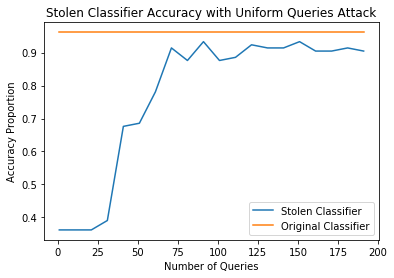

In [51]:
# Plot the accuracy
plt.plot(query_num,accs)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Classifier Accuracy with Uniform Queries Attack")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")
plt.gca().legend(('Stolen Classifier','Original Classifier'))

## Adaptive Training Attack

Next we run an adaptive training attack where the stolen model thusfar is queried to find which points to query next.

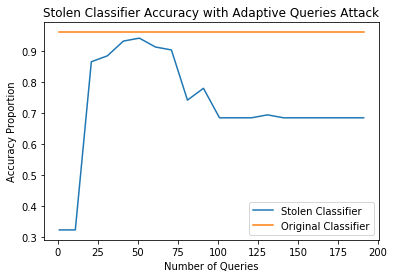

In [69]:
query_data2 = query_data
query_num2 = np.arange(1,int(query_data.shape[0]/5),10)
accs2 = np.zeros(query_num.size)
accs_idx = 0

temp_samp = query_data.sample(n=0)

for num in query_num2:
    # take subset of query data and obtain labels from real classifier
    if num > 1: # Not first instance - we query our own NN and find good points to ask
        num2 = num - query_num2[accs_idx-1]
        new_samp = query_data.sample(n=num2 * 5)
        ns2 = torch.from_numpy(new_samp.values/axes_max).float()
        
        # Query own database and find least secure points
        confs = NN_ad.predict(ns2,True)[1]
        max_confs = np.amax(confs,axis=1)
        idxs = max_confs.argsort()[:num2]
        
        np_samp_min = new_samp.iloc[idxs,:]
        temp_samp = temp_samp.append(np_samp_min/axes_max)
        
        samp = torch.from_numpy(temp_samp.values).float()
        sweep_labels = NN.predict(samp,True)[0]
        sweep_labels = torch.from_numpy(sweep_labels).float()

        # Sub-loop to run stochastic gradient descent multiple times
        NN_ad = Neural_Network()

        for i in range(1000):  # trains the NN 1,000 times
            NN_ad.train(samp, sweep_labels)
            NN_ad.saveWeights(NN_ad)
        
    else: # First instance - we do same as uniform query
        num2 = num
        new_samp = query_data.sample(n=num2)
        temp_samp = temp_samp.append(new_samp/axes_max)
        samp = torch.from_numpy(temp_samp.values).float()
        sweep_labels = NN.predict(samp,True)[0]
        sweep_labels = torch.from_numpy(sweep_labels).float()

        # Sub-loop to run stochastic gradient descent multiple times
        NN_ad = Neural_Network()

        for i in range(1000):  # trains the NN 1,000 times
            NN_ad.train(samp, sweep_labels)
            NN_ad.saveWeights(NN_ad)

    # Build stolen classifier with output data
    sweep_pred = NN_ad.predict(torch.from_numpy(total_test_data.values/axes_max).float(),True)
    accs2[accs_idx] = accuracy_score(total_test_label,sweep_pred[0])
        
    accs_idx += 1
    
# Plot the accuracy
plt.plot(query_num,accs2)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Classifier Accuracy with Adaptive Queries Attack")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")
plt.gca().legend(('Stolen Classifier','Original Classifier'))

We see that the initial learning rate is better than the random uniform query case. However, as we only query near the boundary, we exploit more than explore and lose performance near the end due to us training on only similar data points.

In order to balance exploitation and exploration, we will implement a simple mechanism here. For query numbers below 25, we will aggressively search for low confidence points. Afterwards, we will query with uniform fashion.

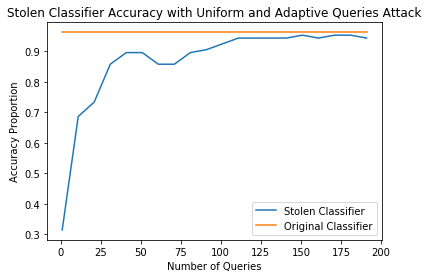

In [64]:
query_data3 = query_data
query_num3 = np.arange(1,int(query_data.shape[0]/5),10)
accs3 = np.zeros(query_num.size)
accs_idx = 0
threshold = 25

temp_samp = query_data.sample(n=0)

for num in query_num3:
    # take subset of query data and obtain labels from real classifier
    if num > 1 and num < threshold: # Not first instance - we query our own NN and find good points to ask
        num2 = num - query_num3[accs_idx-1]
        new_samp = query_data.sample(n=num2 * 5)
        ns2 = torch.from_numpy(new_samp.values/axes_max).float()
        
        # Query own database and find least secure points
        confs = NN_ad.predict(ns2,True)[1]
        max_confs = np.amax(confs,axis=1)
        idxs = max_confs.argsort()[:num2]
        
        np_samp_min = new_samp.iloc[idxs,:]
        temp_samp = temp_samp.append(np_samp_min/axes_max)
        
        samp = torch.from_numpy(temp_samp.values).float()
        sweep_labels = NN.predict(samp,True)[0]
        sweep_labels = torch.from_numpy(sweep_labels).float()

        # Sub-loop to run stochastic gradient descent multiple times
        NN_ad = Neural_Network()

        for i in range(1000):  # trains the NN 1,000 times
            NN_ad.train(samp, sweep_labels)
            NN_ad.saveWeights(NN_ad)
    elif num >= threshold:
        num2 = num - query_num3[accs_idx-1]
        new_samp = query_data.sample(n=num2)

        temp_samp = temp_samp.append(new_samp/axes_max)
        
        samp = torch.from_numpy(temp_samp.values).float()
        sweep_labels = NN.predict(samp,True)[0]
        sweep_labels = torch.from_numpy(sweep_labels).float()

        # Sub-loop to run stochastic gradient descent multiple times
        NN_ad = Neural_Network()

        for i in range(1000):  # trains the NN 1,000 times
            NN_ad.train(samp, sweep_labels)
            NN_ad.saveWeights(NN_ad)
        
    else: # First instance - we do same as uniform query
        num2 = num
        new_samp = query_data.sample(n=num2)
        temp_samp = temp_samp.append(new_samp/axes_max)
        samp = torch.from_numpy(temp_samp.values).float()
        sweep_labels = NN.predict(samp,True)[0]
        sweep_labels = torch.from_numpy(sweep_labels).float()

        # Sub-loop to run stochastic gradient descent multiple times
        NN_ad = Neural_Network()

        for i in range(1000):  # trains the NN 1,000 times
            NN_ad.train(samp, sweep_labels)
            NN_ad.saveWeights(NN_ad)

    # Build stolen classifier with output data
    sweep_pred = NN_ad.predict(torch.from_numpy(total_test_data.values/axes_max).float(),True)
    accs3[accs_idx] = accuracy_score(total_test_label,sweep_pred[0])
        
    accs_idx += 1
    
# Plot the accuracy
plt.plot(query_num3,accs3)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Classifier Accuracy with Uniform and Adaptive Queries Attack")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")
plt.gca().legend(('Stolen Classifier','Original Classifier'))

## Comparing All Different Approaches

Here we compare all three methods of attack.

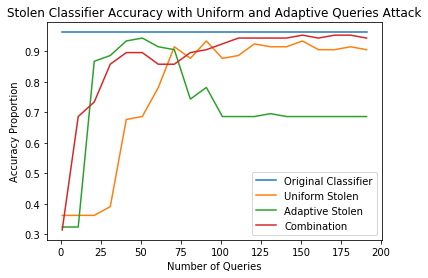

In [70]:
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.plot(query_num,accs)
plt.plot(query_num2,accs2)
plt.plot(query_num3,accs3)

plt.title("Stolen Classifier Accuracy with Uniform and Adaptive Queries Attack")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")
plt.gca().legend(('Original Classifier','Uniform Stolen','Adaptive Stolen','Combination'))

We observe that the adaptive attack allows the stolen NN to perform better with fewer queries. However, the sample space for training becomes redundant as the number of queries. Overall, a combination of adaptive queries near the beginning of the query and uniform near the end has the best performance.